In [68]:
import random
import warnings
import networkx as nx
import matplotlib.pyplot as plt

from queue import Queue

%matplotlib inline
warnings.filterwarnings('ignore')

In [69]:
def init_graph(n, weight=1):
    G = nx.Graph()
    G.add_nodes_from(range(n), weight=weight)
    
    return G

In [70]:
def create_conn_graph(n, fn):
    # Create graph with given number of nodes
    G = init_graph(n)
    
    # While G is not connected
    while not fn(G):
        # Sample 2 nodes from G
        a, b = random.sample(list(G), 2)
        
        # Add edge
        G.add_edge(a, b)
        
    return G

In [71]:
def create_pref_graph(n, fn):
    # Create graph with given number of nodes
    G = init_graph(n)
    
    # While G is not connected
    while not fn(G):
        # Create a bag with nodes, each node has as many elements as its weight
        probs = [[node] * G.node[node]['weight'] for node in G.nodes]
        
        # Flatten the list
        probs = [y for x in probs for y in x]
        
        # Pick a node from G and a node from probality list
        a, b = random.choice(list(G)), random.choice(probs)
        
        # Add edge
        G.add_edge(a, b)
        
        try:
            # Try to find a cycle
            nx.find_cycle(G)
        
            # If so, remove the selected edge
            G.remove_edge(a, b)
        except:
            # Else, increment weight of nodes
            G.node[a]['weight'] += 1 
            G.node[b]['weight'] += 1
            
    return G

In [72]:
def init_queues(length):
    return [Queue() for _ in range(0, length)]

def init_nodes(length):
    return [0] * length

In [73]:
def nodes_with_messages(queue):
    # Filter nodes with messages only
    nodes = list(filter(lambda x: not x.empty(), queue))
    
    return len(nodes)

def neighbors(graph, node, percentage=100):
    # Sample a percentage group of neighbors
    return random.sample(
        list(graph.neighbors(node)),
        round(len(list(graph.neighbors(node))) * percentage/100)
    )

In [74]:
def broadcast(G, percentage):
    # Init queues
    phase = 0
    discover_queue = Queue()                    # discover queue
    reached = init_nodes(nx.number_of_nodes(G)) # list of reached nodes
    queues = init_queues(nx.number_of_nodes(G)) # individual nodes queues

    # Round 0 #
    # Pick an initial node
    initial_node = random.choice(list(G))
    
    for node in neighbors(G, initial_node, percentage):
        # Put each neighbor node in discover queue
        discover_queue.put(node)
        # Put current round in its node queue
        queues[node].put(phase)
    
    # Mark initial_node to reached
    reached[initial_node] = 1
    # Increment round
    phase += 1

    # Next rounds #
    # While there are nodes with messages
    while nodes_with_messages(queues) != 0:
        # Create a new empty discover queue
        next_discover_queue = Queue()
        
        # While discover queue is not empty
        while not discover_queue.empty():
            # Get next_node from queue
            next_node = discover_queue.get()
            
            # Mark next_node to reached if not already
            if reached[next_node] == 0:
                reached[next_node] = 1
                
                # Clear queue of next_node since its reached
                with queues[next_node].mutex:
                    queues[next_node].queue.clear()
                
                # For each neighbor of next_node
                for node in neighbors(G, next_node, percentage):
                    if reached[node] == 0:
                        # If not reached
                        # Put node in next discover queue
                        next_discover_queue.put(node)
                        # Put next round in its node queue
                        queues[node].put(phase+1)
        
        # Increment round
        phase += 1
        # Set current discover queue to the following one
        discover_queue = next_discover_queue
    
    # Percentage of reached nodes in G
    return reached.count(1) / nx.number_of_nodes(G) * 100

In [75]:
def draw_plot(x, y, figsize=(14, 8), output_dir=None):
    plt.figure(figsize=figsize)
    plt.xlabel('% Selected')
    plt.ylabel('% Reached')
    
    plt.grid(True)
    
    plt.plot(x, y, marker='o', label='g(x)')  
    
    if output_dir is not None:
        plt.savefig(output_dir)

In [76]:
def make_broadcast(n, trials, create, fn, pct):
    # Create graph
    G = create(n, fn)
    
    # Sum the percentages
    total = sum([
        broadcast(G, pct)
        for _ in range(trials)
    ])
    
    # Return average percentage
    return total / trials

In [77]:
def main():
    nodes = 100
    trials = 10
    step = 10
    begin = 0
    end = 100 + step
    cond = lambda x : nx.is_connected(x)
    
    results = [
        (pct, make_broadcast(nodes, trials, create_conn_graph, cond, pct))
        for pct in range(begin, end, step)
    ]
    
    x, y = list(zip(*results))

    draw_plot(x, y)

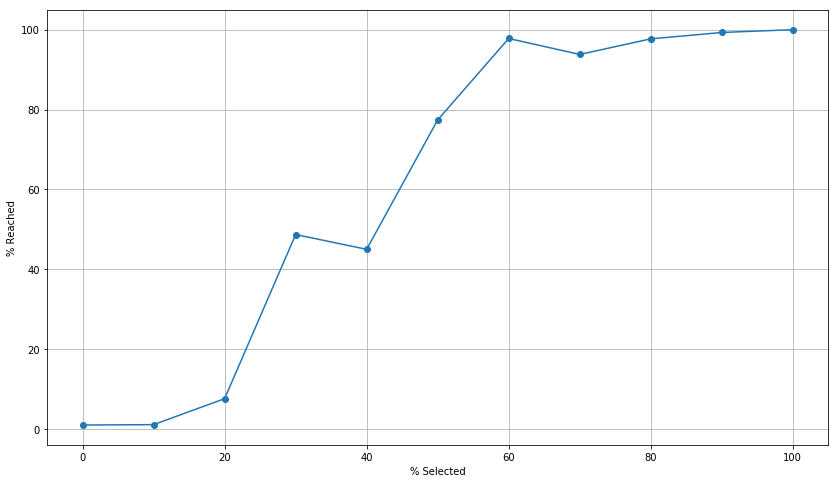

In [78]:
if __name__ == '__main__':
    main()